In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from pathlib import Path

### Define parameters

In [2]:
N = 11 # nodes
D = N - 1 # dimensions

In [3]:
# define transfer functions
f_d = nn.Softplus()
f_l = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0])) # call using f_l.cdf(x)

In [4]:
# output directory
out_dict = "/Users/nguyentiendung/GitHub/perceptual-straightening/model/"

### Define optimizer

In [14]:
class ELBO(nn.Module):
    """
    Class for optimizing the ELBO term. 

    Input:
    ------
    N: Scalar
        Number of nodes
    """
    
    def __init__(self, N):
        super(ELBO, self).__init__()

        # define small noise variables
        eps = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0])) 
        eta = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([np.pi])) 

        # initialize means of the prior
        self.mu_d = nn.Parameter(torch.tensor([0.2 * eps.sample() for _ in range(N - 1)]))
        self.mu_c = nn.Parameter(torch.FloatTensor(N - 2).uniform_(0, np.pi))
        self.mu_a = nn.Parameter(torch.zeros((N - 2) * (N - 1)), requires_grad=False)
        self.mu_l = nn.Parameter(torch.tensor([0.0]), requires_grad=False)

        # initialize (diagonal) covariance matrices of the prior
        self.sigma_d = nn.Parameter(torch.diag(torch.ones(N - 1)))
        self.sigma_c = nn.Parameter(torch.diag(torch.ones(N - 2)))
        self.sigma_a = nn.Parameter(torch.diag(torch.ones((N - 1) * (N - 2))))
        self.sigma_l = nn.Parameter(torch.diag(torch.tensor([1.0])), requires_grad=False)

        # initialize means of the approximate posterior
        M = (N - 1) + (N - 2) + (N - 2) * (N - 1) + 1 # same shape as mu_prior defined below, sum over the dimension of each variable (d, c, a, l)
        self.mu_posterior = nn.Parameter(torch.randn(M)) 

        # initialize matrix for the lower-triangular of the approximate prior 
        self.A = nn.Parameter(torch.abs(torch.randn(M, M))) # variance cannot be negative

    def _make_prior_posterior(self):
        """
        Defines means and covariances for the prior and posterior according to the initialization scheme. 
        Then creates prior and posterior distributions.

        Outputs:
        --------
        prior: torch.distribution object
            Prior distribution p_{theta}(z)
        posterior: torch.distribution object
            Posterior distribution q_{phi}(z|x)
        
        """
        
        # define means and covariances
        mu_prior = torch.cat((self.mu_d, self.mu_c, torch.flatten(self.mu_a), self.mu_l))
        sigma_prior = torch.block_diag(self.sigma_d, self.sigma_c, self.sigma_a, self.sigma_l)

        # transform matrix into lower-triangular matrix via Cholensky decomposition for approximate prior
        A = self.A @ self.A.t().conj() # creates a Hermitian positive-definite matrix
        L, _ = torch.linalg.cholesky_ex(A) 

        # define Distribution objects for prior and posterior
        prior = torch.distributions.MultivariateNormal(mu_prior, sigma_prior)
        posterior = torch.distributions.MultivariateNormal(self.mu_posterior, scale_tril=L)
        
        return prior, posterior

    def kl_divergence(self):
        """
        Computes KL-divergence between posterior and prior.

        Output:
        -------
        kl: Scalar torch tensor
            KL-divergence term
        """

        prior, posterior = self._make_prior_posterior()
        kl = torch.distributions.kl.kl_divergence(posterior, prior)
        return kl

    def _transform(self, x, var):
        """
        Feed variables through the respective transfer functions.

        Inputs:
        -------
        x: torch tensor
            Variable to transform
        var: String
            Denotes which variable to transform, defined for "d" and "l". "c" is not transformed. For "a", the orthogonalization
            depends on the previous displacement vector and will therefore be computed during the trajectory construction.

        Output:
        -------
        x_trans: torch tensor
            Transformed variable
        """
    
        if var == 'd':
            f = nn.Softplus()
            y = f(x)
        elif var == 'l':
            f = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0])) 
            y = 0.06 * f.cdf(x)
        else:
            raise Exception("Unrecognized value for `var`.")

        return y

    def construct_trajectory(self):
        """
        
        """

In [6]:
elbo = ELBO(N)
# print(list(elbo.parameters()))

lr = 1e-4
optimizer = torch.optim.Adam(elbo.parameters(), lr=lr)
model_file = Path(out_dict) / 'model.pt'

In [ ]:
# contruct trajectory for testing purposes


In [7]:
# train loop
iterations = 50000
errors = np.zeros(iterations)
for i in range(iterations):
    loss = elbo.kl_divergence()
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    errors[i] = loss.item()

    if not i % 5000:
        print(f"Epoch: {i}, Loss: {loss.item()}")

# save model
torch.save(elbo.state_dict(), model_file)

Epoch: 0, Loss: 5978.6982421875
Epoch: 5000, Loss: 778.4336547851562
Epoch: 10000, Loss: 230.16995239257812
Epoch: 15000, Loss: 62.76206970214844
Epoch: 20000, Loss: 9.100921630859375
Epoch: 25000, Loss: 0.26641368865966797
Epoch: 30000, Loss: 0.00014781951904296875
Epoch: 35000, Loss: 3.337860107421875e-05
Epoch: 40000, Loss: 9.5367431640625e-06
Epoch: 45000, Loss: 5.7220458984375e-06


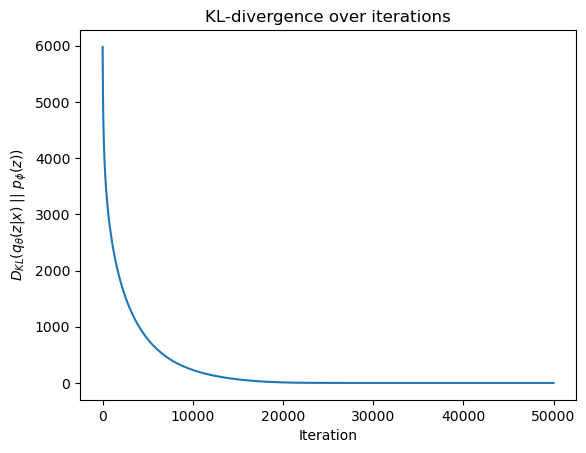

In [8]:
plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel(r'$D_{KL}(q_{\theta}(z|x)$ || $p_{\phi}(z)$)')
plt.title('KL-divergence over iterations')
plt.savefig(Path(out_dict) / f"error_{iterations}")
plt.show()

### Load saved parameters

In [9]:
model = ELBO(N)
model.load_state_dict(torch.load(model_file))
# print(list(elbo.parameters()))

<All keys matched successfully>

### Construct trajectories

In [10]:
class Trajectory:
    """
    Class for the reconstruction of perceptual trajectories. Note that the means of the prior and posterior should have converged to (almost) the same values, 
    same for the variances. 

    Inputs:
    -------
        model: Saved state_dict of a trained torch model
            Contains learned model parameters
        N: Scalar
            Number of nodes
    """

    def __init__(self, model, N):
        
        # get starting indices for slicing
        d_size = N - 1
        c_size = N - 2
        a_size = (N - 1) * (N - 2)
        
        # extract means of the posterior
        q_mu_d = model.mu_posterior.detach()[:d_size]
        q_mu_c = model.mu_posterior.detach()[d_size:d_size + c_size]
        q_mu_a = model.mu_posterior.detach()[d_size + c_size:d_size + c_size + a_size]
        q_mu_l = model.mu_posterior.detach()[-1]

        # extract variances of the prior
        A = model.A @ model.A.t().conj()
        q_sigma_d = A.detach()[:d_size, :d_size]
        q_sigma_c = A.detach()[d_size:d_size + c_size, d_size:d_size + c_size]
        q_sigma_a = A.detach()[d_size + c_size:d_size + c_size + a_size, 
                                    d_size + c_size:d_size + c_size + a_size]
        q_sigma_l = A.detach()[-1:, -1:]   

        # define prior probability distributions
        self.prior_d = torch.distributions.MultivariateNormal(model.mu_d.detach(), model.sigma_d.detach())
        self.prior_c = torch.distributions.MultivariateNormal(model.mu_c.detach(), model.sigma_c.detach())
        self.prior_a = torch.distributions.MultivariateNormal(model.mu_a.detach(), model.sigma_a.detach())
        print(model.mu_a.detach().shape)
        print(model.sigma_a.detach().shape)
        self.prior_l = torch.distributions.Normal(model.mu_l.detach(), model.sigma_l.detach())

        # define posterior probability distributions
        self.posterior_d = torch.distributions.MultivariateNormal(q_mu_d, q_sigma_d)
        self.posterior_c = torch.distributions.MultivariateNormal(q_mu_c, q_sigma_c)
        self.posterior_a = torch.distributions.MultivariateNormal(q_mu_a, q_sigma_a)
        print(q_mu_a.shape)
        print(q_sigma_a.shape)
        self.posterior_l = torch.distributions.Normal(q_mu_l, q_sigma_l)

    def construct_trajectory(self):
        pass

In [11]:
traj = Trajectory(model, N)

torch.Size([90])
torch.Size([90, 90])
torch.Size([90])
torch.Size([90, 90])


In [12]:
traj.posterior_a.sample()

tensor([ 2.6529,  2.0634, -0.5966,  1.2201,  1.3934,  0.7064, -1.3518,  0.4531,
         0.8891, -1.3683,  0.2505, -0.7057,  1.7807, -2.0757, -0.0092,  2.8440,
         1.7981,  3.7064,  0.4925, -0.1713, -1.2213,  0.9513,  0.7459,  0.3868,
         2.1118, -1.6830, -1.2437,  0.7372,  2.1626,  1.3559,  1.2656, -0.5511,
         2.0847, -0.7530,  1.2642, -2.0224,  0.1054,  1.7112,  0.8404, -0.5538,
         0.5462,  0.7588, -0.7877, -2.4391, -2.3450,  0.9065,  0.4847, -0.5721,
         0.0638,  0.3484,  0.9705, -0.7423,  0.1500,  0.2929,  1.3289,  1.0213,
         0.4701, -0.5417,  0.3173,  1.4570,  0.9746, -0.8187, -1.0775, -0.7161,
        -0.0618, -0.9586, -0.0659,  0.6907, -0.2009, -0.2285,  2.0775, -0.3003,
         0.9634,  0.8777, -1.1618,  0.0524, -2.4057, -0.4381, -0.3474, -1.1927,
        -0.2131, -1.6532, -0.4192,  1.3887,  0.5858,  2.3584, -0.0768,  1.6667,
         1.3453,  2.7991])

In [13]:
traj.prior_a.sample()

tensor([-1.3781,  1.8942,  1.1532, -0.1099, -0.1058, -0.3975, -1.1143,  0.6925,
         1.2455,  2.9894, -0.0910, -0.3499, -2.2752,  2.3947, -1.6256, -0.8883,
        -2.4694, -1.2370, -1.1827,  0.4998,  4.0717,  0.5754,  0.4855, -0.9722,
        -1.6772, -0.0955, -1.3773,  0.4312, -1.1740,  0.9233, -1.6718, -1.6509,
        -1.0986,  0.3589,  0.1501,  1.0966,  1.3493,  1.1641,  0.8379, -0.2177,
         0.7667,  0.5576, -0.0614, -0.0837, -0.5029, -0.0044, -0.4700,  0.1238,
        -0.3059,  0.6178, -1.4795, -1.1930, -2.1756,  0.3217, -0.7404, -1.5529,
         1.3410, -0.7694, -0.6189, -0.0791, -0.4891, -1.3790,  0.7335, -0.7130,
        -1.6773,  0.5639, -0.8349,  2.5899,  0.6558, -0.3648, -3.7765, -1.1871,
        -1.3050,  0.9675,  1.0178, -0.4986,  0.9666, -1.6723, -0.3811, -1.6596,
         0.1951,  0.5630,  0.9302,  1.0369, -0.2309,  1.2364,  0.7806,  1.7611,
         1.5230, -1.4030])